In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import uniform
from urllib.request import urlopen
import seaborn as sns

# 1. Load UCI Letter Recognition dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
col_names = ['letter', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 
             'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']

data = pd.read_csv(url, header=None, names=col_names)

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   x-box   20000 non-null  int64 
 2   y-box   20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   high    20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   x-bar   20000 non-null  int64 
 7   y-bar   20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybr   20000 non-null  int64 
 12  xy2br   20000 non-null  int64 
 13  x-ege   20000 non-null  int64 
 14  xegvy   20000 non-null  int64 
 15  y-ege   20000 non-null  int64 
 16  yegvx   20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB
None

=== First 5 Rows ===
  letter  x-box  y-box  width  high  onpix  x-bar  y-bar  x2bar  y2bar  xybar  \
0      T      2      8     

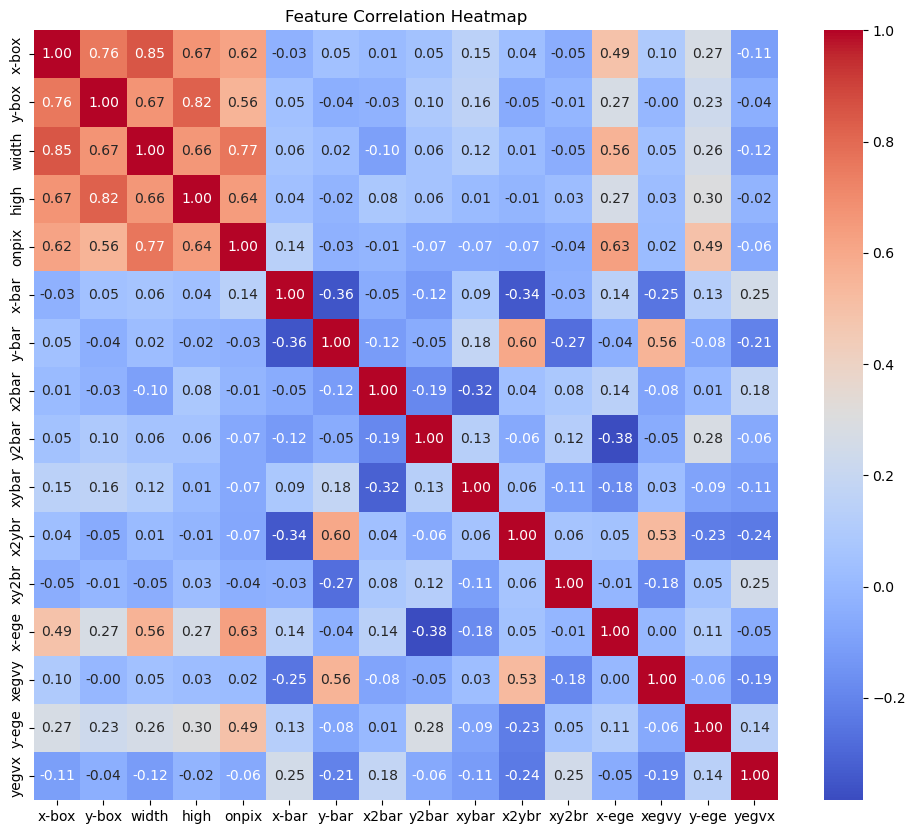

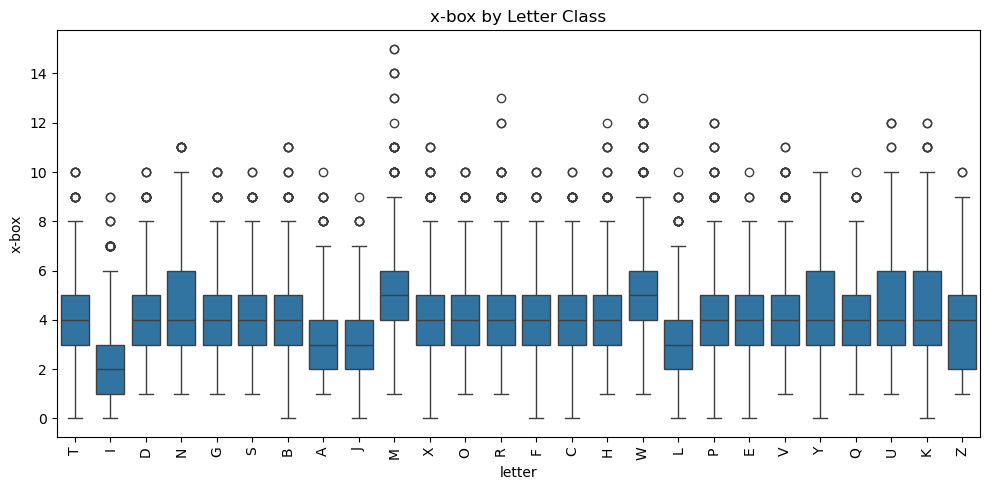

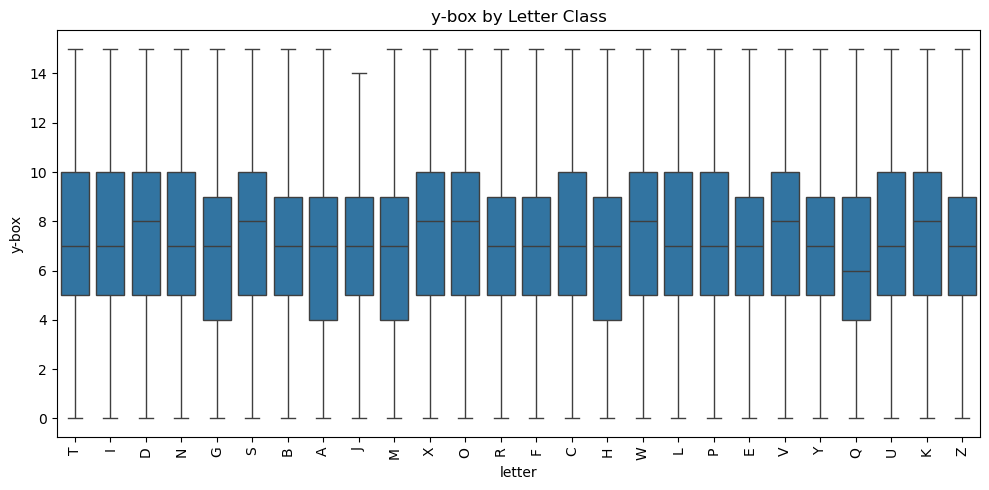

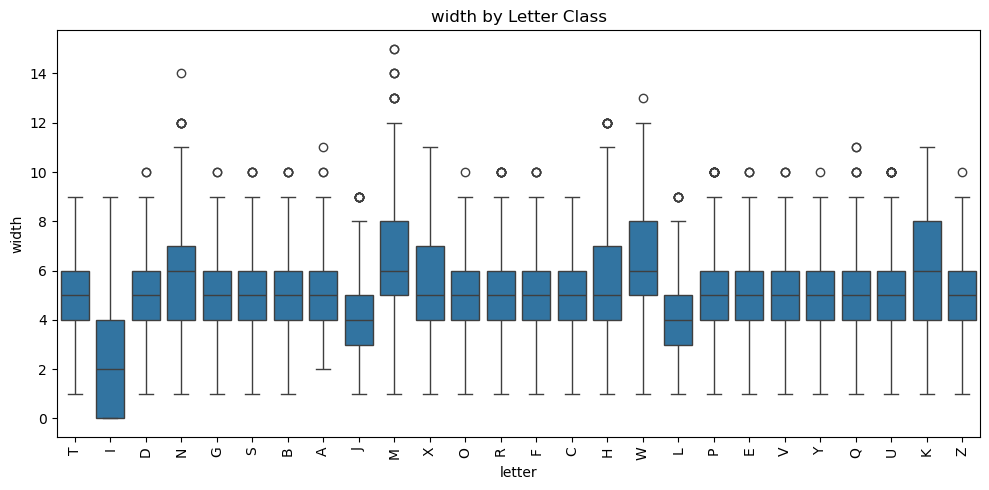

In [3]:
# 1. Basic Info
print("=== Dataset Info ===")
print(data.info())

# 2. First few rows
print("\n=== First 5 Rows ===")
print(data.head())

# 3. Check for missing values
print("\n=== Missing Values ===")
print(data.isnull().sum())

# 4. Class distribution (multi-class target)
print("\n=== Class Distribution ===")
print(data['letter'].value_counts())

# 5. Summary statistics
print("\n=== Summary Statistics ===")
print(data.describe())

# 6. Correlation heatmap (excluding target label)
plt.figure(figsize=(12, 10))
sns.heatmap(data.drop('letter', axis=1).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Feature Correlation Heatmap')
plt.show()

# 7. Boxplot of a few features grouped by letter
features_to_plot = ['x-box', 'y-box', 'width']
for feature in features_to_plot:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='letter', y=feature, data=data)
    plt.title(f'{feature} by Letter Class')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [7]:
# 2. Preprocess data
X = data.drop('letter', axis=1)
y = LabelEncoder().fit_transform(data['letter'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Setup for SVM Optimization
results = []
max_accuracy = 0
best_fitness_over_time = []
best_sample_index = -1

# 4. SVM Hyperparameter space
param_distributions = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

# 5. Run for 10 samples
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=i)

    model = SVC()
    random_search = RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=100,
        scoring='accuracy',
        n_jobs=-1,
        cv=3,
        verbose=0,
        random_state=42,
        return_train_score=False
    )
    
    random_search.fit(X_train, y_train)
    y_pred = random_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    best_params = random_search.best_params_
    results.append({
        'Sample': f'S{i+1}',
        'Accuracy': accuracy,
        'Best Params': f"{best_params['kernel']}, C={best_params['C']:.2f}, degree={best_params['degree']}, gamma={best_params['gamma']}"
    })

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_sample_index = i
        best_fitness_over_time = random_search.cv_results_['split0_test_score']

# 6. Create Results Table
df_results = pd.DataFrame(results)
print(df_results)

  Sample  Accuracy                         Best Params
0     S1  0.972333   rbf, C=9.92, degree=5, gamma=auto
1     S2  0.966667   rbf, C=9.92, degree=5, gamma=auto
2     S3  0.970667  rbf, C=9.90, degree=5, gamma=scale
3     S4  0.967500   rbf, C=9.76, degree=3, gamma=auto
4     S5  0.964333  rbf, C=9.10, degree=4, gamma=scale
5     S6  0.969333   rbf, C=9.92, degree=5, gamma=auto
6     S7  0.966000   rbf, C=8.66, degree=3, gamma=auto
7     S8  0.970167  rbf, C=9.90, degree=5, gamma=scale
8     S9  0.971333   rbf, C=9.92, degree=5, gamma=auto
9    S10  0.971333   rbf, C=9.76, degree=3, gamma=auto


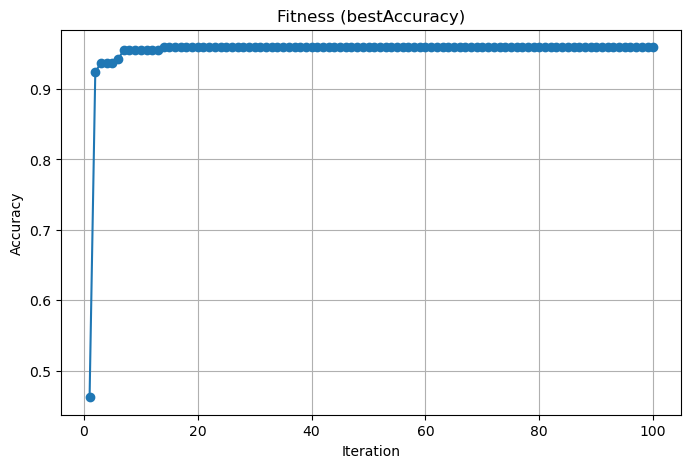

In [17]:
# 7. Plot convergence of best sample
scores = random_search.cv_results_['mean_test_score']
best_fitness_over_time = np.maximum.accumulate(scores)
plt.figure(figsize=(8,5))
plt.plot(np.linspace(1, 100, len(best_fitness_over_time)), best_fitness_over_time, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Fitness (bestAccuracy)')
plt.grid(True)
plt.show()